# Figure 2

In this notebook, we'll generate figure panels for use in Figure 2, the overview of Bortezomib treatment results.

For the UMAP plots, see the notebook for Figure 1. In this notebook, we'll generate the differential result barplots, Hallmark Pathway heatmaps, and motif enrichment volcano plots.

## Load packages

hise: The Human Immune System Explorer R SDK package  
purrr: Functional programming tools  
dplyr: Dataframe handling functions  
ggplot2: plotting functions  
cowplot: multi-panel plot assembly

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(ggrastr)
quiet_library(cowplot)

In [2]:
out_dir <- "output/figure_2"
if(!dir.exists(out_dir)) { dir.create(out_dir, recursive = TRUE) }

## Retrieve files

Now, we'll use the HISE SDK package to retrieve the analysis results for DEG, Hallmark Pathway enrichment, and motif enrichment.

DEG: Differentially expressed genes

In [3]:
deg_uuid <- list("fc83b89f-fd26-43b8-ac91-29c539703a45")

In [4]:
deg_fres <- cacheFiles(deg_uuid)
deg_file <- list.files(
    paste0("cache/",deg_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



[1] "Initiating file download for all_mast_deg_2023-09-06.csv"
[1] "Download successful."


DEP: Differentially expressed proteins (ADT)

In [9]:
dep_uuid <- list("4cbaa9ab-f8ef-495d-ac5e-1f1d99d33e33")

In [10]:
dep_fres <- cacheFiles(dep_uuid)
dep_file <- list.files(
    paste0("cache/",dep_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



[1] "Initiating file download for all_lm_dep_2023-10-09.csv"
[1] "Download successful."


DAP: Differentially accessible peaks (ATAC)

In [11]:
dap_uuid <- list("f2acae35-2e36-4885-970f-1e45f69ac3b8")

In [12]:
dap_fres <- cacheFiles(dap_uuid)
dap_file <- list.files(
    paste0("cache/",dap_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



[1] "Initiating file download for all-archr-dap_2023-10-07.csv"
[1] "Download successful."


In [5]:
hallmark_uuid <- list("4f05f2a0-59d2-4d04-b948-70d541613e71")

In [6]:
hallmark_fres <- cacheFiles(hallmark_uuid)
hallmark_file <- list.files(
    paste0("cache/",hallmark_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



[1] "Initiating file download for all_hallmark_gsea_res_2023-09-06.csv"
[1] "Download successful."


In [7]:
dem_uuid <- list("af70c9a6-7d73-46bd-a719-f5a3c410ed15")

In [8]:
dem_fres <- cacheFiles(dem_uuid)
dem_file <- list.files(
    paste0("cache/",dem_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



[1] "Initiating file download for all-archr-dem_2023-10-07.csv"
[1] "Download successful."


## Differential expression barplots

### DEG Barplots

In [13]:
fdr_cutoff <- 0.05

In [23]:
type_colors <- read.csv("../common/color_sets/aifi_cell_type_colors.csv")

In [24]:
all_deg <- read.csv(deg_file)

In [25]:
all_deg <- all_deg %>%
  mutate(
      direction_sign = ifelse(
          is.na(logFC),
          sign(coef_D),
          sign(logFC)
      ),
      direction = ifelse(
          direction_sign == 1,
          "up", "dn"
      )
  )

In [26]:
all_deg <- all_deg %>%
  filter(fg == "bortezomib")

In [36]:
deg_summary <- all_deg %>%
  group_by(fg, timepoint, aifi_cell_type, n_sample) %>%
  summarise(n_sig = sum(adjP < fdr_cutoff),
            n_up = sum(adjP < fdr_cutoff & direction == "up"),
            n_dn = sum(adjP < fdr_cutoff & direction == "dn"),
            .groups = "keep")

In [37]:
plot_data <- deg_summary %>%
  rename(aifi_cell_type = aifi_cell_type) %>%
  left_join(type_colors) %>%
  mutate(treat_time = paste0(fg,"_",timepoint)) %>%
  group_by(fg) %>%
  mutate(max_val = max(c(n_up, n_dn))) %>%
  ungroup()

Joining with `by = join_by(aifi_cell_type)`


In [38]:
plot_data %>%
  filter(fg == "bortezomib",
         aifi_cell_type == "t_cd4_naive")

fg,timepoint,aifi_cell_type,n_sample,n_sig,n_up,n_dn,cell_type_label,cell_type_color,cell_type_xpos,cell_type_ypos,treat_time,max_val
<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<int>
bortezomib,4,t_cd4_naive,1352,0,0,0,CD4 Naive,#93A7D1,1,7,bortezomib_4,3181
bortezomib,24,t_cd4_naive,1352,247,165,82,CD4 Naive,#93A7D1,1,7,bortezomib_24,3181
bortezomib,72,t_cd4_naive,1352,5802,3181,2621,CD4 Naive,#93A7D1,1,7,bortezomib_72,3181


In [ ]:
write.csv(
    plot_data,
    file.path(out_dir, paste0("bortezomib_deg_summary_data_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)

In [39]:
options(repr.plot.width = 12, repr.plot.height = 4)
treat_plots <- map(
    treat_times,
    function(tt) {
                
        pd <- plot_data %>%
          filter(treat_time == tt)
        
        x_max <- pd$max_val[1]
        x_min <- -1 * x_max
        x_breaks <- unique(c(seq(signif(x_min, 1), 0, length.out = 3),
                             seq(0, signif(x_max, 1), length.out = 3)))
        
        timepoint <- pd$timepoint[1]
        pd_max <- max(max(pd$n_dn), max(pd$n_up))
        if(pd_max < 100) {
            pd_max <- 100
        }
        
        up_pd <- pd %>%
          mutate(xmin = 0, xmax = n_up,
                 fill = "orangered")
        dn_pd <- pd %>%
          mutate(xmin = -1 * n_dn, xmax = 0,
                 fill = "dodgerblue")
        
        pd <- rbind(up_pd, dn_pd)
        
        plot_ypos <- pd %>%
          select(aifi_cell_type, cell_type_label, 
                 cell_type_color, cell_type_ypos, 
                 n_sample, n_sig) %>%
          unique()
        
        p <- ggplot()
        
        if(timepoint == 4) {
            x_lim <- c(x_min * 3.5, x_max * 1.1)
            
            p <- p + geom_rect(data = plot_ypos,
                    aes(ymin = cell_type_ypos - 0.5, ymax = cell_type_ypos + 0.5,
                        xmin = x_min * 3.5, xmax = x_min * 1.1,
                        fill = cell_type_color),
                    alpha = 0.8) +
            geom_text(data = plot_ypos,
                    aes(x = x_min * 1.6, y = cell_type_ypos,
                        label = cell_type_label),
                    hjust = 1,
                    vjust = 0.5) +
            geom_text(data = plot_ypos,
                    aes(x = x_min * 1.2, y = cell_type_ypos,
                        label = n_sample),
                    hjust = 1)
            
        } else {
            x_lim <- c(x_min * 1.1, x_max * 1.1)
        }
        p <- p +
          geom_rect(data = plot_ypos,
                    aes(ymin = cell_type_ypos - 0.5, ymax = cell_type_ypos + 0.5,
                        xmin = x_min * 1.1, xmax = x_max * 1.1,
                        fill = cell_type_color),
                    alpha = 0.3) +
          geom_rect(data = pd,
                   aes(ymin = cell_type_ypos - 0.35, ymax = cell_type_ypos + 0.35,
                       xmin = xmin, xmax = xmax,
                       fill = fill)) +
          geom_vline(data = data.frame(x = 0),
                     aes(xintercept = x)) +
          scale_y_continuous("",
                             limits = c(min(plot_ypos$cell_type_ypos) - 0.5, max(plot_ypos$cell_type_ypos) + 0.5)) +
          scale_fill_identity() +
          scale_x_continuous(paste0("N DEGs\n(FDR < ",fdr_cutoff,")"),
                             limits = x_lim,
                             breaks = x_breaks,
                             expand = c(0,0)) +
          theme_bw(base_size = 16) +
          facet_wrap(~ timepoint, ncol = 3) +
          theme(panel.grid.major.y = element_blank(),
                panel.grid.minor = element_blank(),
                axis.ticks = element_blank(),
                axis.text.y = element_blank(),
                panel.border = element_blank(),
                strip.background = element_blank())
        
        p
    }
)
names(treat_plots) <- treat_times

In [40]:
treat_times

[1] "bortezomib_4"  "bortezomib_24" "bortezomib_72"

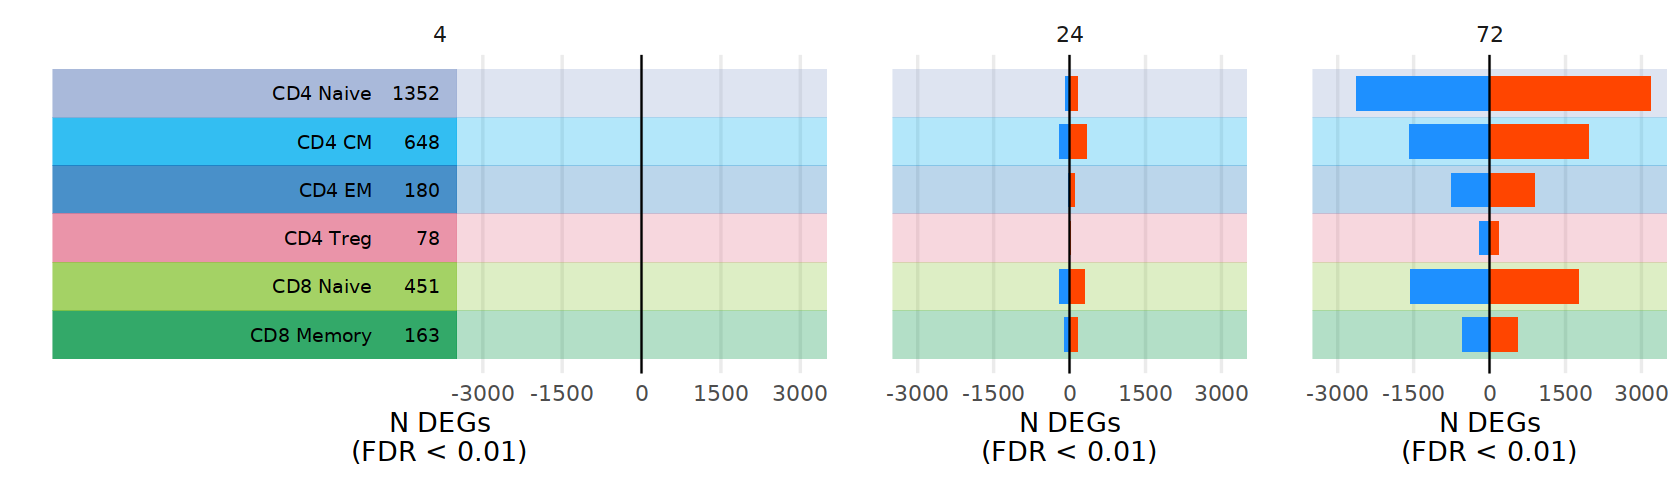

In [41]:
options(repr.plot.width = 14, repr.plot.height = 4)
all_plots <- plot_grid(
    plotlist = treat_plots,
    nrow = 1, ncol = 3,
    rel_widths = c(2,1,1)
)
all_plots

In [42]:
out_file <- file.path(
    out_dir,
    paste0("bortezomib_deg_barplot_",Sys.Date(),".pdf")
)
ggsave(out_file,
       all_plots,
       width = 14, height = 4)

### DAP Barplots

In [43]:
fdr_cutoff <- 0.05

In [44]:
all_dap <- read.csv(dap_file)

In [45]:
head(all_dap)

,aifi_cell_type,fg,bg,seqnames,start,end,logFC,adjP,MeanDiff,idx
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
1,t_cd4_cm,bortezomib_4,dmso_4,chr1,817080,817580,0.71758991,0.9672773,0.015274370,1
2,t_cd4_cm,bortezomib_4,dmso_4,chr1,827320,827820,-0.01365454,0.9672773,-0.002301029,2
3,t_cd4_cm,bortezomib_4,dmso_4,chr1,844410,844910,-0.77546781,0.9672773,-0.019452669,3
4,t_cd4_cm,bortezomib_4,dmso_4,chr1,903854,904354,-0.88964343,0.9672773,-0.009819916,8
5,t_cd4_cm,bortezomib_4,dmso_4,chr1,904492,904992,-0.24471014,0.9672773,-0.044446448,9
6,t_cd4_cm,bortezomib_4,dmso_4,chr1,942394,942894,-0.89070139,0.9672773,-0.039526604,22


In [46]:
all_dap <- all_dap %>%
  mutate(timepoint = sub(".+_","",fg),
         fg = sub("_.+","",fg),
         bg = sub("_.+","",bg)) %>%
  filter(fg == "bortezomib") %>%
  mutate(direction = ifelse(logFC > 0, "up", "dn"))

In [47]:
head(all_dap)

,aifi_cell_type,fg,bg,seqnames,start,end,logFC,adjP,MeanDiff,idx,timepoint,direction
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,t_cd4_cm,bortezomib,dmso,chr1,817080,817580,0.71758991,0.9672773,0.015274370,1,4,up
2,t_cd4_cm,bortezomib,dmso,chr1,827320,827820,-0.01365454,0.9672773,-0.002301029,2,4,dn
3,t_cd4_cm,bortezomib,dmso,chr1,844410,844910,-0.77546781,0.9672773,-0.019452669,3,4,dn
4,t_cd4_cm,bortezomib,dmso,chr1,903854,904354,-0.88964343,0.9672773,-0.009819916,8,4,dn
5,t_cd4_cm,bortezomib,dmso,chr1,904492,904992,-0.24471014,0.9672773,-0.044446448,9,4,dn
6,t_cd4_cm,bortezomib,dmso,chr1,942394,942894,-0.89070139,0.9672773,-0.039526604,22,4,dn


In [48]:
table(all_dap$aifi_cell_type)


    t_cd4_cm     t_cd4_em  t_cd4_naive   t_cd4_treg t_cd8_memory  t_cd8_naive 
      220388       213581       203460       174095       204682       218512 

In [50]:
dap_summary <- all_dap %>%
  group_by(fg, timepoint, aifi_cell_type) %>%
  summarise(n_sig = sum(adjP < fdr_cutoff),
            n_up = sum(adjP < fdr_cutoff & direction == "up"),
            n_dn = sum(adjP < fdr_cutoff & direction == "dn"),
            .groups = "keep")

In [52]:
head(dap_summary)

fg,timepoint,aifi_cell_type,n_sig,n_up,n_dn
<chr>,<chr>,<chr>,<int>,<int>,<int>
bortezomib,24,t_cd4_cm,5,5,0
bortezomib,24,t_cd4_em,47,47,0
bortezomib,24,t_cd4_naive,2,2,0
bortezomib,24,t_cd4_treg,23,23,0
bortezomib,24,t_cd8_memory,178,171,7
bortezomib,24,t_cd8_naive,56,52,4


In [53]:
plot_data <- dap_summary %>%
  left_join(type_colors) %>%
  mutate(treat_time = paste0(fg,"_",timepoint)) %>%
  group_by(fg) %>%
  mutate(max_val = max(c(n_up, n_dn))) %>%
  ungroup()

Joining with `by = join_by(aifi_cell_type)`


In [55]:
plot_data %>%
  filter(fg == "bortezomib",
         aifi_cell_type == "t_cd4_naive")

fg,timepoint,aifi_cell_type,n_sig,n_up,n_dn,cell_type_label,cell_type_color,cell_type_xpos,cell_type_ypos,treat_time,max_val
<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<int>
bortezomib,24,t_cd4_naive,2,2,0,CD4 Naive,#93A7D1,1,7,bortezomib_24,3812
bortezomib,4,t_cd4_naive,0,0,0,CD4 Naive,#93A7D1,1,7,bortezomib_4,3812
bortezomib,72,t_cd4_naive,2853,1793,1060,CD4 Naive,#93A7D1,1,7,bortezomib_72,3812


In [ ]:
write.csv(
    plot_data,
    file.path(out_dir, paste0("bortezomib_dap_summary_data_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)

In [56]:
treat_times <- unique(plot_data$treat_time)
treat_times

[1] "bortezomib_24" "bortezomib_4"  "bortezomib_72"

In [57]:
options(repr.plot.width = 12, repr.plot.height = 4)
treat_plots <- map(
    treat_times,
    function(tt) {
        
        pd <- plot_data %>%
          filter(treat_time == tt)
        
        x_max <- pd$max_val[1]
        x_min <- -1 * x_max
        x_breaks <- unique(c(seq(signif(x_min, 1), 0, length.out = 3),
                             seq(0, signif(x_max, 1), length.out = 3)))
        x_max <- max(x_max, x_breaks[length(x_breaks)])
        x_min <- min(x_min, x_breaks[1])
        
        timepoint <- pd$timepoint[1]

        up_pd <- pd %>%
          mutate(xmin = 0, xmax = n_up,
                 fill = "orangered")
        dn_pd <- pd %>%
          mutate(xmin = -1 * n_dn, xmax = 0,
                 fill = "dodgerblue")
        
        pd <- rbind(up_pd, dn_pd)
        
        plot_ypos <- pd %>%
          select(aifi_cell_type, cell_type_label, 
                 cell_type_color, cell_type_ypos, 
                 n_sig) %>%
          unique()
        
        p <- ggplot()
        
        if(timepoint == 4) {
            x_lim <- c(x_min * 3.5, x_max * 1.1)
            
            p <- p + geom_rect(data = plot_ypos,
                    aes(ymin = cell_type_ypos - 0.5, ymax = cell_type_ypos + 0.5,
                        xmin = x_min * 3.5, xmax = x_min * 1.1,
                        fill = cell_type_color),
                    alpha = 0.8) +
            geom_text(data = plot_ypos,
                    aes(x = x_min * 1.6, y = cell_type_ypos,
                        label = cell_type_label),
                    hjust = 1,
                    vjust = 0.5)
            
        } else {
            x_lim <- c(x_min * 1.1, x_max * 1.1)
        }
        p <- p +
          geom_rect(data = plot_ypos,
                    aes(ymin = cell_type_ypos - 0.5, ymax = cell_type_ypos + 0.5,
                        xmin = x_min * 1.1, xmax = x_max * 1.1,
                        fill = cell_type_color),
                    alpha = 0.3) +
          geom_rect(data = pd,
                   aes(ymin = cell_type_ypos - 0.35, ymax = cell_type_ypos + 0.35,
                       xmin = xmin, xmax = xmax,
                       fill = fill)) +
          geom_vline(data = data.frame(x = 0),
                     aes(xintercept = x)) +
          scale_y_continuous("",
                             limits = c(min(plot_ypos$cell_type_ypos) - 0.5, max(plot_ypos$cell_type_ypos) + 0.5)) +
          scale_fill_identity() +
          scale_x_continuous(paste0("N DAPs\n(FDR < ",fdr_cutoff,")"),
                             limits = x_lim,
                             breaks = x_breaks,
                             expand = c(0,0)) +
          theme_bw(base_size = 16) +
          facet_wrap(~ timepoint, ncol = 3) +
          theme(panel.grid.major.y = element_blank(),
                panel.grid.minor = element_blank(),
                axis.ticks = element_blank(),
                axis.text.y = element_blank(),
                panel.border = element_blank(),
                strip.background = element_blank())
        
        p
    }
)
names(treat_plots) <- treat_times

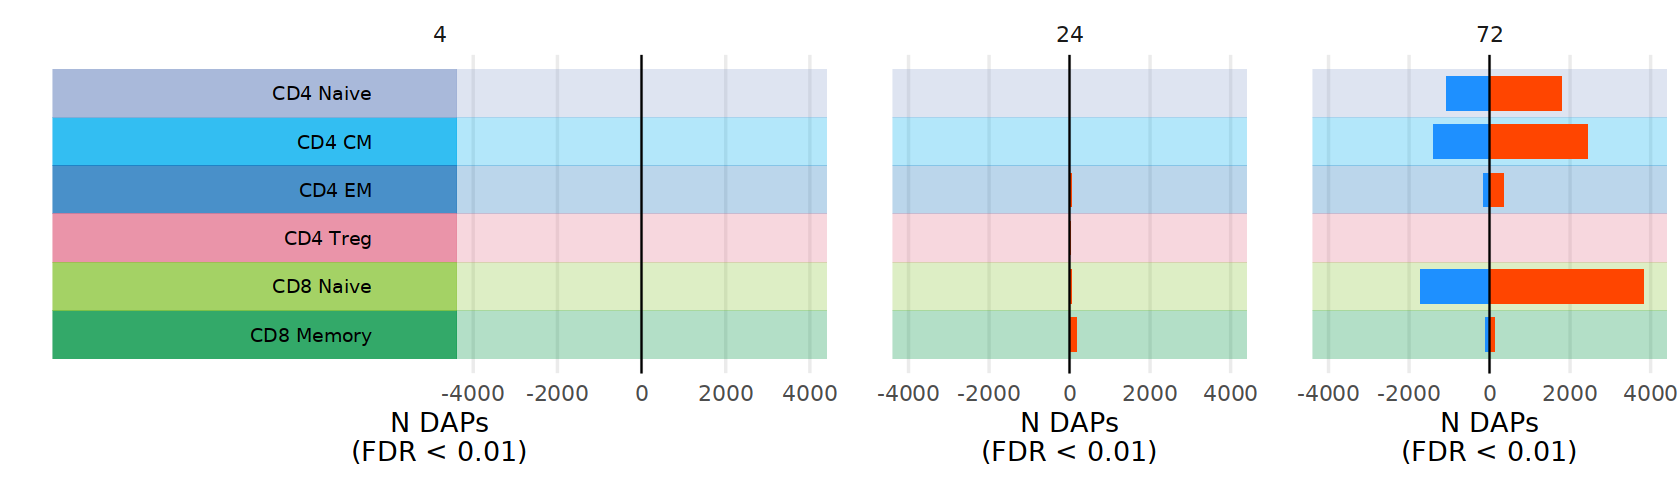

In [61]:
options(repr.plot.width = 14, repr.plot.height = 4)
all_plots <- plot_grid(
    plotlist = treat_plots[c("bortezomib_4","bortezomib_24","bortezomib_72")],
    nrow = 1, ncol = 3,
    rel_widths = c(2,1,1)
)
all_plots

In [62]:
out_file <- file.path(
    out_dir,
    paste0("bortezomib_dap_barplot_",Sys.Date(),".pdf")
)
ggsave(out_file,
       all_plots,
       width = 14, height = 4)

### DDE Barplots
Differentially detected epitopes, aka Differentially expressed proteins (DEP)

In [63]:
fdr_cutoff <- 0.05

In [64]:
all_dep <- read.csv(dep_file)

In [85]:
all_dep <- all_dep %>%
  filter(fg == "bortezomib") %>%
  mutate(direction = ifelse(logFC > 0, "up", "dn"))

In [86]:
dep_epitope_summary <- all_dep %>%
  filter(adjP < fdr_cutoff) %>%
  group_by(fg, feature, direction) %>%
  summarise(n_types_up = n(), .groups = "keep")

In [87]:
dep_summary <- all_dep %>%
  group_by(fg, timepoint, aifi_cell_type) %>%
  summarise(n_sig = sum(adjP < fdr_cutoff),
            n_up = sum(adjP < fdr_cutoff & direction == "up"),
            n_dn = sum(adjP < fdr_cutoff & direction == "dn"),
            .groups = "keep")

In [89]:
plot_data <- dep_summary %>%
  left_join(type_colors) %>%
  mutate(treat_time = paste0(fg,"_",timepoint)) %>%
  group_by(fg) %>%
  mutate(max_val = max(c(n_up, n_dn))) %>%
  ungroup()

Joining with `by = join_by(aifi_cell_type)`


In [91]:
plot_data %>%
  filter(fg == "bortezomib",
         aifi_cell_type == "t_cd4_naive")

fg,timepoint,aifi_cell_type,n_sig,n_up,n_dn,cell_type_label,cell_type_color,cell_type_xpos,cell_type_ypos,treat_time,max_val
<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<int>
bortezomib,4,t_cd4_naive,4,2,2,CD4 Naive,#93A7D1,1,7,bortezomib_4,12
bortezomib,24,t_cd4_naive,3,1,2,CD4 Naive,#93A7D1,1,7,bortezomib_24,12
bortezomib,72,t_cd4_naive,19,12,7,CD4 Naive,#93A7D1,1,7,bortezomib_72,12


In [ ]:
write.csv(
    plot_data,
    file.path(out_dir, paste0("bortezomib_dde_summary_data_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)

In [92]:
treat_times <- unique(plot_data$treat_time)
treat_times

[1] "bortezomib_4"  "bortezomib_24" "bortezomib_72"

In [93]:
options(repr.plot.width = 12, repr.plot.height = 4)
treat_plots <- map(
    treat_times,
    function(tt) {
        
        pd <- plot_data %>%
          filter(treat_time == tt)
        
        x_max <- pd$max_val[1]
        x_min <- -1 * x_max
        x_breaks <- unique(c(seq(signif(x_min, 1), 0, length.out = 3),
                             seq(0, signif(x_max, 1), length.out = 3)))
        
        timepoint <- pd$timepoint[1]
        
        up_pd <- pd %>%
          mutate(xmin = 0, xmax = n_up,
                 fill = "orangered")
        dn_pd <- pd %>%
          mutate(xmin = -1 * n_dn, xmax = 0,
                 fill = "dodgerblue")
        
        pd <- rbind(up_pd, dn_pd)
        
        plot_ypos <- pd %>%
          select(aifi_cell_type, cell_type_label, 
                 cell_type_color, cell_type_ypos, 
                 n_sig) %>%
          unique()
        
        p <- ggplot()
        
        if(timepoint == 4) {
            x_lim <- c(x_min * 3.5, x_max * 1.1)
            
            p <- p + geom_rect(data = plot_ypos,
                    aes(ymin = cell_type_ypos - 0.5, ymax = cell_type_ypos + 0.5,
                        xmin = x_min * 3.5, xmax = x_min * 1.1,
                        fill = cell_type_color),
                    alpha = 0.8) +
            geom_text(data = plot_ypos,
                    aes(x = x_min * 1.6, y = cell_type_ypos,
                        label = cell_type_label),
                    hjust = 1,
                    vjust = 0.5)
            
        } else {
            x_lim <- c(x_min * 1.1, x_max * 1.1)
        }
        p <- p +
          geom_rect(data = plot_ypos,
                    aes(ymin = cell_type_ypos - 0.5, ymax = cell_type_ypos + 0.5,
                        xmin = x_min * 1.1, xmax = x_max * 1.1,
                        fill = cell_type_color),
                    alpha = 0.3) +
          geom_rect(data = pd,
                   aes(ymin = cell_type_ypos - 0.35, ymax = cell_type_ypos + 0.35,
                       xmin = xmin, xmax = xmax,
                       fill = fill)) +
          geom_vline(data = data.frame(x = 0),
                     aes(xintercept = x)) +
          scale_y_continuous("",
                             limits = c(min(plot_ypos$cell_type_ypos) - 0.5, max(plot_ypos$cell_type_ypos) + 0.5)) +
          scale_fill_identity() +
          scale_x_continuous(paste0("N DDEs\n(FDR < ",fdr_cutoff,")"),
                             limits = x_lim,
                             breaks = x_breaks,
                             expand = c(0,0)) +
          theme_bw(base_size = 16) +
          facet_wrap(~ timepoint, ncol = 3) +
          theme(panel.grid.major.y = element_blank(),
                panel.grid.minor = element_blank(),
                axis.ticks = element_blank(),
                axis.text.y = element_blank(),
                panel.border = element_blank(),
                strip.background = element_blank())
        
        p
    }
)
names(treat_plots) <- treat_times

In [94]:
treat_times

[1] "bortezomib_4"  "bortezomib_24" "bortezomib_72"

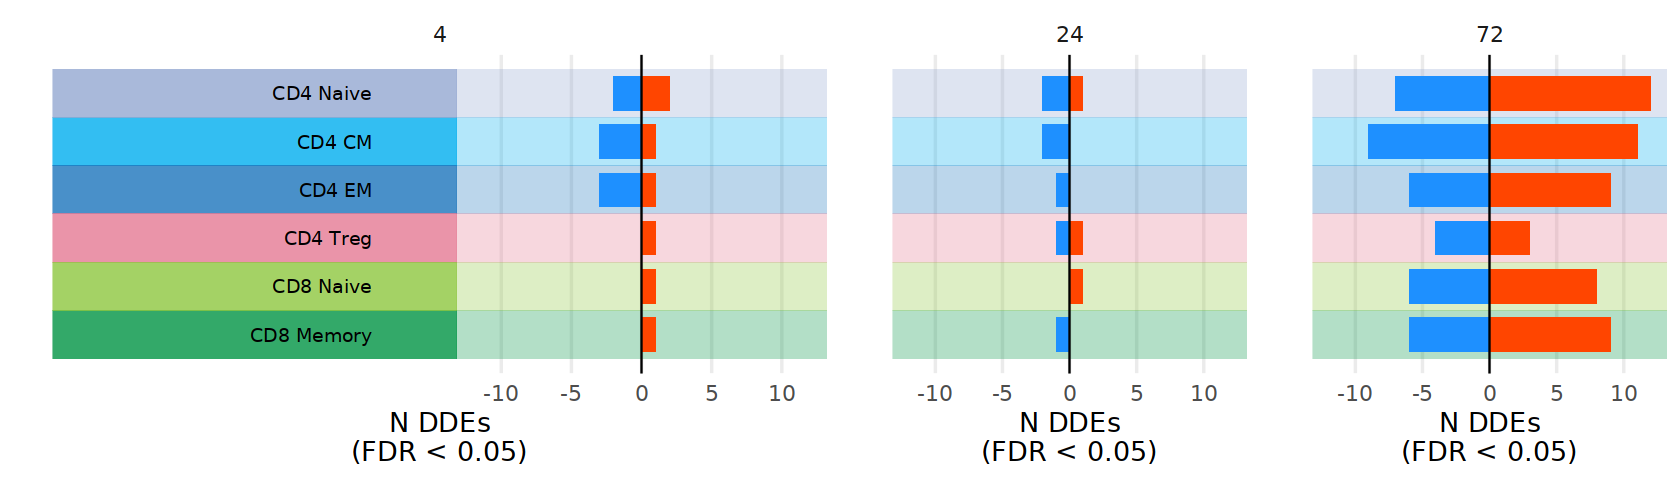

In [95]:
options(repr.plot.width = 14, repr.plot.height = 4)
treat_plots <- treat_plots[c("bortezomib_4", "bortezomib_24", "bortezomib_72")]
all_plots <- plot_grid(
    plotlist = treat_plots,
    nrow = 1, ncol = 3,
    rel_widths = c(2,1,1)
)
all_plots

In [96]:
out_file <- file.path(
    out_dir,
    paste0("bortezomib_dde_barplot_",Sys.Date(),".pdf")
)
ggsave(out_file,
       all_plots,
       width = 14, height = 4)

## Hallmark pathway enrichment heatmaps

In [97]:
fdr_cutoff <- 0.1

In [98]:
hallmark_names <- read.csv("../common/gene_sets/hallmark_names.csv")

In [99]:
type_colors <- read.csv("../common/color_sets/aifi_cell_type_colors.csv")

Gradient colors

In [101]:
lo_gc <- data.frame(NES = seq(-3, -1.01, 0.01)) %>%
  mutate(nes_color = colorRampPalette(c("darkblue", "skyblue"))(n()))
mid_lo_gc <- data.frame(NES = seq(-1, 0, 0.01), nes_color = "gray80")
hi_gc <- data.frame(NES = seq(3,1.01,-0.01)) %>%
  mutate(nes_color = colorRampPalette(c("darkred", "coral"))(n()))
mid_hi_gc <- data.frame(NES = seq(1, 0.01, -0.01), nes_color = "gray80")

gc_df <- do.call(rbind, list(lo_gc, mid_lo_gc, mid_hi_gc, hi_gc))
gc_df$NES <- as.character(gc_df$NES)

In [102]:
all_hallmark <- read.csv(hallmark_file)

In [104]:
all_hallmark <- all_hallmark %>%
  filter(fg == "bortezomib")

In [103]:
head(all_hallmark)

,fg,bg,timepoint,aifi_cell_type,pathway_label,NES,nomP,adjP,n_leadingEdge,n_pathway_genes,leadingEdge,pathway_genes
,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>
1,bortezomib,dmso,24,t_cd4_cm,MYC Targets V1,2.013740,7.204018e-08,3.385888e-06,180,236,PSMD1;PSMD14;PSMB2;PSMD7;PSMA6;PSMC6;RAD23B;PSMD3;PSMB3;PSMA7;HSP90AB1;NAP1L1;PSMC4;SRSF2;PSMA4;PSMA2;CCT3;PTGES3;PSMA1;UBE2L3;PSMD8;XRCC6;CUL1;EIF3J;IFRD1;SRPK1;GLO1,ABCE1;ACP1;AIMP2;AP3S1;APEX1;BUB3;C1QBP;CAD;CANX;CANX;CBX3;CCNA2;CCT2;CCT3;CCT4;CCT5;CCT7;CDC20;CDC45;CDK2;CDK4;CLNS1A;CNBP;COPS5;COX5A;CSTF2;CTPS1;CUL1;CYC1;DDX18;DDX21;DEK;DHX15;DUT;EEF1B2;EEF1B2;EIF1AX;EIF2S1;EIF2S2;EIF3B;EIF3D;EIF3J;EIF4A1;EIF4E;EIF4G2;EIF4H;EIF4H;EPRS1;ERH;ETF1;EXOSC7;FAM120A;FBL;FBL;G3BP1;GLO1;GNL3;GOT2;GSPT1;H2AZ1;HDAC2;HDDC2;HDGF;HNRNPA1;HNRNPA2B1;HNRNPA3;HNRNPC;HNRNPD;HNRNPR;HNRNPR;HNRNPU;HPRT1;HSP90AB1;HSPD1;HSPE1;IARS1;IFRD1;ILF2;IMPDH2;KARS1;KPNA2;KPNB1;LDHA;LDHA;LSM2;LSM2;LSM2;LSM2;LSM2;LSM2;LSM7;MAD2L1;MCM2;MCM4;MCM5;MCM6;MCM7;MRPL23;MRPL23;MRPL9;MRPS18B;MRPS18B;MRPS18B;MRPS18B;MRPS18B;MRPS18B;MRPS18B;MYC;NAP1L1;NCBP1;NCBP2;NDUFAB1;NHP2;NME1;NOLC1;NOP16;NOP56;NPM1;ODC1;ORC2;PA2G4;PABPC1;PABPC4;PCBP1;PCNA;PGK1;PHB;PHB2;POLD2;POLE3;PPIA;PPM1G;PRDX3;PRDX4;PRPF31;PRPF31;PRPF31;PRPF31;PRPF31;PRPF31;PRPF31;PRPF31;PRPF31;PRPF31;PRPS2;PSMA1;PSMA2;PSMA4;PSMA6;PSMA7;PSMB2;PSMB3;PSMB3;PSMC4;PSMC4;PSMC6;PSMD1;PSMD14;PSMD3;PSMD7;PSMD8;PTGES3;PWP1;RACK1;RAD23B;RAN;RANBP1;RFC4;RNPS1;RNPS1;RNPS1;RNPS1;RNPS1;RNPS1;RPL14;RPL18;RPL22;RPL34;RPL6;RPLP0;RPS10;RPS2;RPS3;RPS5;RPS6;RRM1;RRP9;RSL1D1;RUVBL2;SERBP1;SET;SF3A1;SF3B3;SLC25A3;SMARCC1;SNRPA;SNRPA1;SNRPB2;SNRPD1;SNRPD2;SNRPD3;SNRPG;SRM;SRPK1;SRSF1;SRSF2;SRSF3;SRSF7;SSB;SSBP1;SSBP1;STARD7;SYNCRIP;TARDBP;TCP1;TFDP1;TOMM70;TRA2B;TRIM28;TUFM;TXNL4A;TYMS;U2AF1;UBA2;UBE2E1;UBE2L3;USP1;VBP1;VDAC1;VDAC3;XPO1;XPOT;XRCC6;YWHAE;YWHAE;YWHAQ
2,bortezomib,dmso,24,t_cd4_cm,MTORC1 Signaling,1.817862,2.233468e-04,3.499100e-03,142,211,PSMD14;TXNRD1;PSMD12;PSMC6;SQSTM1;PSMC2;PSMA3;NMT1;TBK1;GSR;PSMD13;PRDX1;HSPA9;PSMC4;PSMA4;PSMB5;NUP205;GPI;GBE1;GLA;STIP1;GAPDH;GCLC;IFRD1;ATP2A2;SLC2A3;GLRX;HMGCS1;NIBAN1;GSK3B;HSPD1,ABCF2;ACACA;ACACA;ACLY;ACSL3;ACTR2;ACTR3;ADD3;ADIPOR2;ADIPOR2;AK4;ALDOA;ARPC5L;ASNS;ATP2A2;ATP5MC1;ATP6V1D;AURKA;BCAT1;BHLHE40;BTG2;BUB1;CACYBP;CALR;CANX;CANX;CCNF;CCNG1;CCT6A;CD9;CDC25A;CDKN1A;CFP;COPS5;CORO1A;CTH;CTSC;CXCR4;CYB5B;CYP51A1;DAPP1;DDIT3;DDIT4;DDX39A;DHCR24;DHCR7;DHFR;EBP;EDEM1;EEF1E1;EGLN3;EIF2S2;ELOVL5;ELOVL6;ENO1;EPRS1;ERO1A;ETF1;FADS1;FADS2;FDXR;FGL2;FKBP2;G6PD;GAPDH;GBE1;GCLC;GGA2;GLA;GLRX;GMPS;GOT1;GPI;GPI;GSK3B;GSR;GTF2H1;GTF2H1;HK2;HMBS;HMGCR;HMGCS1;HPRT1;HSP90B1;HSPA4;HSPA5;HSPA9;HSPD1;HSPE1;IDH1;IDI1;IFI30;IFRD1;IGFBP5;IMMT;INSIG1;ITGB2;LDHA;LDHA;LDLR;LGMN;LTA4H;M6PR;MAP2K3;MCM2;MCM4;ME1;MLLT11;MTHFD2;MTHFD2L;NAMPT;NFIL3;NFKBIB;NFKBIB;NFYC;NIBAN1;NMT1;NUFIP1;NUP205;NUPR1;P4HA1;PDAP1;PDK1;PFKL;PGK1;PGM1;PHGDH;PIK3R3;PITPNB;PLK1;PLOD2;PNO1;PNP;POLR3G;PPA1;PPIA;PPP1R15A;PRDX1;PSAT1;PSMA3;PSMA4;PSMB5;PSMC2;PSMC4;PSMC4;PSMC6;PSMD12;PSMD13;PSMD14;PSME3;PSMG1;PSPH;QDPR;RAB1A;RDH11;RIT1;RPA1;RPN1;RRM2;RRP9;SC5D;SCD;SDF2L1;SEC11A;SERP1;SERPINH1;SHMT2;SKAP2;SLA;SLC1A4;SLC1A5;SLC2A1;SLC2A3;SLC37A4;SLC37A4;SLC37A4;SLC6A6;SLC7A11;SLC7A5;SLC9A3R1;SORD;SQLE;SQSTM1;SQSTM1;SRD5A1;SSR1;STARD4;STC1;STIP1;SYTL2;TBK1;TCEA1;TES;TFRC;TM7SF2;TMEM97;TOMM40;TPI1;TRIB3;TUBA4A;TUBG1;TXNRD1;UBE2D3;UCHL5;UFM1;UNG;USO1;VLDLR;WARS1;XBP1;YKT6
3,bortezomib,dmso,24,t_cd4_cm,ROS Pathway,1.755945,9.261899e-03,5.441366e-02,38,58,TXNRD1;TXN;GSR;FTL;PRDX1;GCLM;SOD1;GCLC;PFKP;LAMTOR5;GLRX,ABCC1;ABCC1;ATOX1;CAT;CDKN2D;EGLN2;ERCC2;FES;FTL;G6PD;GCLC;GCLM;GLRX;GLRX2;GPX3;GPX4;GSR;HHEX;HMOX2;HMOX2;IPCEF1;JUNB;LAMTOR5;LSP1;LSP1;MBP;MGST1;MPO;MSRA;MSRA;NDUFA6;NDUFA6;NDUFA6;NDUFA6;NDUFA6;NDUFB4;NDUFS2;NQO1;OXSR1;PDLIM1;PFKP;PRDX1;PRDX2;PRDX4;PRDX6;PRNP;PTPA;SBNO2;SBNO2;SCAF4;SELENOS;SOD1;SOD2;SRXN1;STK25;TXN;TXNRD1;TXNRD2
4,bortezomib,dmso,24,t_cd4_cm,Adipogenesis,1.678625,3.414757e-03,2.621228e-02,121,210,UBC;UBQLN1;TALDO1;NMT1;BAZ2A;SOD1;ACO2;RTN3;GBE1;MAP

Add treat_time, display labels for pathways, and cell type 

In [106]:
plot_hallmark <- all_hallmark %>%
  mutate(label_time = ifelse(timepoint == 4, "04", as.character(timepoint))) %>%
  mutate(treat_time = paste0(fg, "_", label_time)) %>%
  left_join(hallmark_names) %>%
  left_join(type_colors)

Joining with `by = join_by(pathway_label)`
Joining with `by = join_by(aifi_cell_type)`


In [109]:
top_n <- 20

sig_data <- plot_hallmark %>%
  filter(adjP < fdr_cutoff) %>%
  group_by(pathway) %>%
  arrange(adjP) %>%
  slice(1) %>%
  ungroup() %>%
  arrange(adjP) %>%
  head(top_n)

plot_data <- plot_hallmark %>%
  filter(pathway %in% sig_data$pathway)

xpos_df <- plot_data %>%
  select(cell_type_label, cell_type_xpos) %>%
  unique() %>%
  arrange(cell_type_xpos) %>%
  mutate(xpos = 1:n())

ypos_df <- plot_data %>%
  select(pathway_label) %>%
  unique() %>%
  arrange(pathway_label) %>%
  mutate(ypos = n():1)

timepoint_df <- data.frame(
    timepoint = c(4, 24, 72),
    timepoint_label = factor(c("Bortezomib, 4 Hours", "Bortezomib, 24 Hours", "Bortezomib, 72 Hours"), 
                             levels = c("Bortezomib, 4 Hours", "Bortezomib, 24 Hours", "Bortezomib, 72 Hours"))
)

plot_data <- plot_data %>%
  left_join(xpos_df) %>%
  left_join(ypos_df) %>%
  mutate(NES = as.character(round(NES, 2))) %>%
  left_join(gc_df) %>%
  left_join(timepoint_df)

Joining with `by = join_by(cell_type_label, cell_type_xpos)`
Joining with `by = join_by(pathway_label)`
Joining with `by = join_by(NES)`
Joining with `by = join_by(timepoint)`


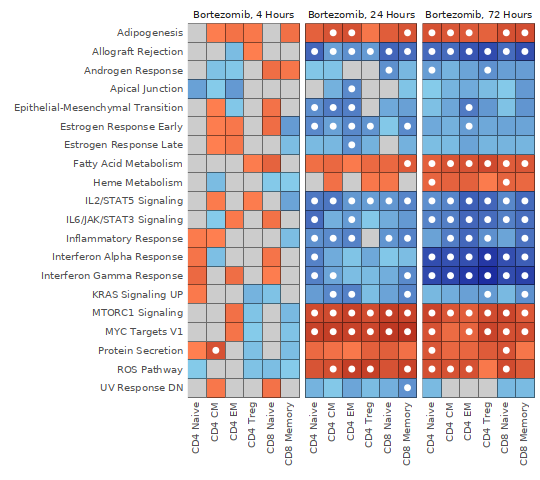

In [113]:
options(repr.plot.width = 4.5, repr.plot.height = 4)
hallmark_plot <- ggplot() +
  geom_tile(
      data = plot_data,
      aes(x = xpos,
          y = ypos,
          fill = nes_color),
      color = "black") +
  geom_point(
      data = plot_data %>% filter(adjP < fdr_cutoff),
      aes(x = xpos,
          y = ypos),
      color = "white",
      size = 0.9) +
  scale_fill_identity() +
  scale_x_continuous(
      "",
      breaks = xpos_df$xpos,
      labels = xpos_df$cell_type_label,
      expand = c(0, 0)) +
  scale_y_continuous(
      "",
      breaks = ypos_df$ypos,
      labels = ypos_df$pathway_label,
      expand = c(0, 0)) +
  facet_wrap(~ timepoint_label) +
  theme_bw(base_size = 7) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.3),
        panel.border = element_blank(),
        axis.ticks = element_blank(),
        strip.background = element_blank(),
        panel.grid = element_blank(),
        panel.background = element_rect(fill = "gray30"))
hallmark_plot

In [114]:
out_file <- file.path(
    out_dir,
    paste0("bortezomib_hallmark_heatmap_",Sys.Date(),".pdf")
)
ggsave(out_file,
       hallmark_plot,
       width = 14, height = 4)

## Motif enrichment volcano plots

In [156]:
all_dem <- read.csv(dem_file)

In [157]:
all_dem <- all_dem %>%
  mutate(timepoint = sub(".+_","",fg),
         fg = sub("_.+","",fg),
         bg = sub("_.+","",bg)) %>%
  filter(fg == "bortezomib")

Set Enrichment to negative values for motifs enriched near down-regulated genes

In [158]:
all_dem <- all_dem %>%
  mutate(Enrichment = ifelse(
      direction == "dn",
      -1 * Enrichment,
      Enrichment))

In [159]:
plot_dem <- all_dem %>%
  filter(timepoint == 72)

In [161]:
tail(plot_dem)

,aifi_cell_type,fg,bg,direction,feature,tf_gene,Enrichment,nomP,adjP,mlog10Padj,mlog10p,BackgroundProporition,nBackground,BackgroundFrequency,CompareProportion,nCompare,CompareFrequency,timepoint
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<chr>
10435,t_cd8_naive,bortezomib,dmso,dn,RORB_865,RORB,NA,1,1,0,0,0.04598330,73070,3360,NA,0,0,72
10436,t_cd8_naive,bortezomib,dmso,dn,SMAD5_866,SMAD5,NA,1,1,0,0,0.12581087,73070,9193,NA,0,0,72
10437,t_cd8_naive,bortezomib,dmso,dn,SMAD9_867,SMAD9,NA,1,1,0,0,0.05605584,73070,4096,NA,0,0,72
10438,t_cd8_naive,bortezomib,dmso,dn,SOX6_868,SOX6,NA,1,1,0,0,0.06381552,73070,4663,NA,0,0,72
10439,t_cd8_naive,bortezomib,dmso,dn,TBX18_869,TBX18,NA,1,1,0,0,0.04252087,73070,3107,NA,0,0,72
10440,t_cd8_naive,bortezomib,dmso,dn,TBX22_870,TBX22,NA,1,1,0,0,0.04252087,73070,3107,NA,0,0,72


Warning message:
“Removed 5220 rows containing missing values (`geom_point()`).”


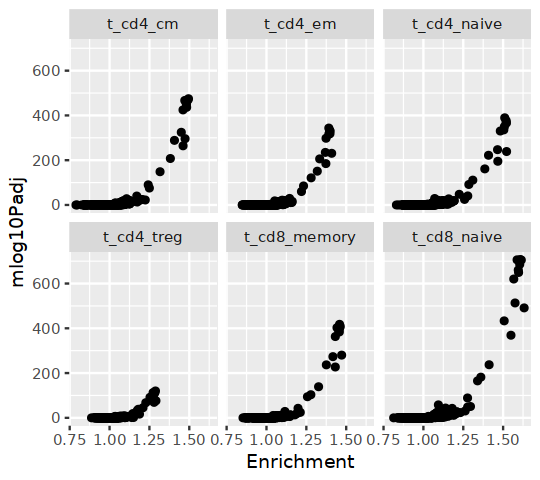

In [147]:
ggplot() +
  geom_point(
      data = plot_dem,
      aes(x = Enrichment,
          y = mlog10Padj)
  ) +
  facet_wrap(
      ~ aifi_cell_type,
      ncol = 3,
      nrow = 2
  )